<a href="https://colab.research.google.com/github/jesusvc5/RL_LAVC/blob/main/MonteCarloOffPolicy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación, análisis y evaluación del método de MonteCarlo Off-Policy de todas las visitas sobre el entorno Frozen Lake

*Description*: En este notebook se desarrolla la implementación del método de **Monte Carlo Off-Policy**, y se emplea sobre el entorno Frozen Lake de Gymnasium.


    Autores: Jesús Verdú Chacón
             Jorge López Abad

    Emails: jesus.v.c@um.es
            jorge.lopeza@um.es
            
    Date: 2025/03/09


In [1]:
%%capture
!pip install 'gym[box2d]==0.20.0'

In [2]:
# Intentamos fijar las semillas
import os
import torch
import gc
import numpy as np

# Configuración del dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Liberación de memoria para evitar problemas de consumo en GPU
gc.collect() # Ejecuta el recolector de basura de Python
torch.cuda.empty_cache() # Vacía la caché de memoria en GPU

SEED = 123

# Fijar la semilla en NumPy
np.random.seed(SEED) # Para generar números aleatorios consistentes en NumPy
np.random.default_rng(SEED) # Establece una instancia del generador de NumPy con la misma semilla

# Fijar la semilla en Python
os.environ['PYTHONHASHSEED'] = str(SEED) # Evita variabilidad en hashing de Python

Usando dispositivo: cpu


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym


## Definición del agente

Vamos ahora a diseñar un agente que emplee la técnica de Monte Carlo Off-Policy de todas las visitas, para el entorno Frozen Lake de Gymnasium. Recordemos que esta, al contrario que la basada en On-Policy, emplea una política distinta para explorar el entorno, que la que realmente busca optimizar. Estas son, respectivamente, la **política de comportamiento** y la **política objetivo**. En este caso usaremos:

* **Política de comportamiento**: $\epsilon$-greedy basada en la $\epsilon$-soft, como la que usábamos en el caso de MonteCarlo On-Policy. Podríamos haber usado cualquier política soft realmente, como una uniforme, pero optamos por esta, pues nos permite más flexibilidad a la hora de experimentar (podemos obtener una uniforme si le damos un valor de $\epsilon=1$ en la declaración de los hiperparámetros).
* **Política objetivo**: Una greedy.

Con respecto a la variante On-Policy, la forma de actualizar los valores $Q$ al final de los episodios también es distinta, pues en este caso se llevan a cabo de la siguiente forma, usando un **muestreo de importancia ponderado**, pues veíamos en teoría que era el que se solía usar en enfoques de todas las visitas y posee una menor varianza. Aunque el método está sesgado, la menor varianza suele conducir a estimaciones más estables y eficientes en la práctica, dando la posibilidad de converger a la política óptima para un número elevado de episodios.

De manera práctica, esto se traducía a la siguiente actualización de los valores $Q$:

$$
Q(S_t, A_t) ← Q(S_t, A_t) + \frac{W}{C(S_t, A_t)} (G_t - Q(S_t, A_t))
$$

donde $G_t$ son los retornos del instante $t$ del episodios, y los valores $C$ y $W$ se actualizan de la siguiente manera:

$$
C(S_t, A_t) ← C(S_t, A_t) +W
$$

$W$ se actualiza en caso de que la política objetivo no establezca como mejor acción, en el instante $t$, la acción que fue escogida por el agente en ese instante del episodio:

$$
W ← W \frac{1}{b(A_t|S_t)}
$$


In [4]:
# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

class AgentMonteCarloOffPolicy:
  def __init__(self,
               env:gym.Env,
               epsilon:float,
               decay:bool,
               discount_factor:float):

    self.env = env
    self.epsilon = epsilon
    self.decay = decay
    self.discount_factor = discount_factor
    self.returns = {}
    self.nA = env.action_space.n
    self.nS = env.observation_space.n

    self.Q = np.zeros((self.nS, self.nA))
    self.C = np.zeros((self.nS, self.nA))
    #self.factor_ini = factor_ini

  def get_Q(self):
    return self.Q

  def set_return(self, state, action, G):
    self.returns[(state, action)].append(G)

  def get_return(self, state, action):
    return self.returns[(state, action)]


  # Política uniforme
  def get_action_uniform(self, state):
    return np.random.choice(np.arange(self.nA))

  def get_uniform_policy(self, state):
    return np.ones(self.nA) / self.nA

  # Epsilon soft
  def get_action_epsilon_soft(self, state):
    pi_A = np.ones(self.nA, dtype=float) * self.epsilon / self.nA
    best_action = np.argmax(self.Q[state])
    pi_A[best_action] += (1.0 - self.epsilon)
    return pi_A

  # Política de comportamiento b. Soft policy (usamos una epsilon-greedy)
  def get_action_behavior_policy( self, state):
    pi_A = self.get_action_epsilon_soft(state)
    return np.random.choice(np.arange(self.nA), p=pi_A)

  def get_pi_behavior_policy(self, state, action):
    pi_A = self.get_action_epsilon_soft(state)
    #pi_A = self.get_uniform_policy(state)
    return pi_A[action]

  # Política greedy
  def target_policy(self, state):
    return np.argmax(self.Q[state, :])


  # Política Greedy a partir de los valones Q. Se usa para mostrar la solución.
  def get_action_greedy_from_Q(self, env):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset() # start in top-left, = 0
    actions = ""
    while not done:
        action = self.target_policy(state)#np.argmax(self.Q[state, :])
        actions += f"{action}, "
        pi_star[state,action] = action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    return pi_star, actions

  # Actualización de los valores Q
  def update(self, episode):
    G = 0
    W = 1
    factor = self.discount_factor # el gamma

    for step in reversed(range(len(episode))):
      state, action, reward = episode[step]
      G = reward + factor * G
      self.C[state, action] += W
      self.Q[state, action] += (W/self.C[state, action]) * (G - self.Q[state, action])
      if action != self.target_policy(state):
        break
      W = W * 1/self.get_pi_behavior_policy(state, action)

    return G




## Esquema general del aprendizaje episódico de un agente (Algoritmo)

Este esquema es idéntico al que veíamos en el notebook `MonteCarloOnPolicy.ipynb`, pues el esquema es igual, sólo cambia la forma de actualizar los valores. Destacar el uso del decaimiento de la $\epsilon$, donde volvemos a utilizar uno que haga que esta sea inversamente proporcional al número de episodios, y que empiece a decaer a partir de un número inicial de episodios que permita la exploración.

In [5]:
import gymnasium as gym

def train(agent, num_episodes):
  stats = 0.0
  list_stats = [stats]
  list_len = []
  step_display = num_episodes / 10
  #np.random.seed(SEED)

  # Ejecutamos n_episodes
  for t in tqdm(range(n_episodes)):
    state, info = agent.env.reset(seed=SEED)
    done = False

    # Para almacenar la información del episodio
    episode = []
    total_reward = 0.0

    # play one episode
    while not done:
      if agent.decay:
        agent.epsilon = min(agent.epsilon, 1000.0/(t+1))

      action = agent.get_action_behavior_policy(state)

      # Generamos una acción de acuerdo a la política de comportamiento
      next_state, reward, terminated, truncated, info = agent.env.step(action)

      episode.append((state, action, reward))

      # update if the environment is done and the current obs
      done = terminated or truncated
      state = next_state

    total_reward = agent.update(episode)

    # Guardamos datos sobre la evolución
    stats += total_reward
    list_stats.append(stats/(t+1))
    list_len.append(len(episode))

    # Para mostrar la evolución.  Comentar si no se quiere mostrar
    if t % step_display == 0 and t != 0:
      print(f"success: {stats/t}, epsilon: {agent.epsilon}")

  return list_stats, list_len


Desarrollamos esta función para, una vez entrenado el agente, evaluar su aprendizaje en el entorno, mediante un video.

In [6]:
# Para la visualización del video

def run_episode_greedy(agent, max_steps=100):
  frames = []
  state, info = agent.env.reset(seed=SEED)

  total_reward = 0.0
  len_episode = 0

  for t in range(max_steps):
    frame = agent.env.render()
    frames.append(frame)
    action = agent.target_policy(state)
    next_state, reward, done, truncated, info = agent.env.step(action)
    total_reward += reward
    state = next_state
    len_episode += 1

  frames.append(agent.env.render())
  agent.env.close()

  return total_reward, len_episode, frames

## Funciones auxiliares

Funciones comúnes que usaremos en todos los notebooks. Serán para visualizar la política greedy final obtenida, el vídeo del comportamiento final del agente, así como las gráficas que nos provean de información intuitiva de la evolución del proceso de aprendizaje.

In [7]:
def qtable_directions_map(qtable, map_size):
    '''
      Para cada estado del mapa (cada celda) nos devuelva la dirección que debe coger el
      agente según la política obtenida.
    '''
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine

    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            qtable_directions[idx] = directions[val]

    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [8]:
import seaborn as sns

def plot_q_values_map(qtable, env, map_size):
    '''
      Ploteamos el último frame del camino que realizaría el agente, junto con un
      las direcciones que toma en función del estado en el que se encuentre, y evaluar.
    '''
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    #img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    #fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [9]:
import imageio

def frames_to_gif(frames, filename="FL_MCOff.gif"):
    """
    Crea un archivo GIF a partir de una lista de fotogramas.

    Parámetros:
      - frames (list): Lista de fotogramas (imágenes) capturados del entorno.
      - filename (str): Nombre del archivo GIF resultante.

    Retorna:
      - str: Nombre del archivo GIF creado.
    """
    # Abrir un escritor de GIF con imageio.
    with imageio.get_writer(filename, mode='I') as writer:
        # Agregar cada fotograma al GIF.
        for frame in frames:
            writer.append_data(frame)
    return filename

In [10]:
import base64
from IPython.display import HTML

def display_gif(gif_path):
    """
    Muestra un GIF en Google Colab.

    Parámetros:
      - gif_path (str): Ruta del archivo GIF.

    Retorna:
      - HTML: Objeto HTML que contiene el GIF incrustado.
    """
    # Abrir el archivo GIF en modo binario.
    with open(gif_path, 'rb') as f:
        video = f.read()
    # Convertir el contenido del GIF a una cadena Base64.
    b64 = base64.b64encode(video)
    # Retornar el objeto HTML que muestra el GIF.
    return HTML(f'')

In [50]:
def plot(list_stats):
  '''
    Plotea la proporción de recompensas a lo largo de los episodios.
  '''
  # Creamos una lista de índices para el eje x
  indices = list(range(len(list_stats)))

  # Creamos el gráfico
  plt.figure(figsize=(10, 4))
  plt.plot(indices, list_stats)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

def plot_comparative(dict_stats):
  '''
    Plotea la proporción de recompensas a lo largo de los episodios de cada elemento de la lista.
    list_stats: Es un diccionario, donde cada clave contiene la información de un agente.
  '''
  # Creamos una lista de índices para el eje x
  indices = range(len(list(dict_stats.values())[0]))
  plt.figure(figsize=(10, 4))

  for key in dict_stats:
    plt.plot(indices, dict_stats[key], label=key)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')
  plt.legend()

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

In [12]:
from scipy import stats

def moving_average(data, window_size):
    '''
      Calcula la media móvil de una serie de datos, para una window_size dada.
    '''
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_len_tendency(list_len):
  '''
    Plotea la longitud del episodio a lo largo de los episodios, junto con la media
    móvil, para visualizar la tendencia.
  '''

  plt.figure(figsize=(10, 4))

  plt.plot(list_len, alpha=0.3, color='green')

  # Curva de media móvil
  window = 100
  avg = moving_average(list_len, window_size=window)
  plt.plot(range(len(avg)), avg, label="Longitud del episodio", color='darkgreen', linewidth=2)

  plt.title('Longitud de los episodios')
  plt.xlabel('Episodio')
  plt.ylabel('Longitud')
  plt.legend()

  plt.grid(True)
  plt.show()

def plot_len_comparative(dict_len):
  '''
    Plotea la longitud del episodio a lo largo de los episodios, junto con la media
    móvil, para visualizar la tendencia, de cada elemento del diccionario.
  '''
  color = ['darkred', 'darkblue', 'darkgreen']

  plt.figure(figsize=(10, 4))
  # Curva de media móvil
  window = 100
  for i, key in enumerate(dict_len):
    plt.plot(dict_len[key], alpha=0.2, color=color[i])
    avg = moving_average(dict_len[key], window_size=window)
    plt.plot(range(len(avg)), avg, label=key, linewidth=2, color=color[i])

  plt.title('Longitud de los episodios')
  plt.xlabel('Episodio')
  plt.ylabel('Longitud')
  plt.legend()

  plt.grid(True)
  plt.show()

## Caso de estudio: FrozenLake

In [13]:
# Fijar la semilla en Gymnasium
def make_env_fl(env_name, map="4x4", render = "ansi", is_slippery=False, max_episode_steps=100):
  env = gym.make(env_name, is_slippery=is_slippery, map_name=map, render_mode=render, max_episode_steps=max_episode_steps)
  env.reset(seed=SEED) # Establece la semilla en el entorno de Gymnasium
  return env

name_fl = 'FrozenLake-v1'

In [14]:
env4 = make_env_fl(name_fl, "4x4", "rgb_array")

Definimos al agente con los siguiente hiperparámetros:
* `env4`: Entorno 4x4 de Frozen Lake.
* `epsilon=0.4`: El valor inicial de epsilon, para que explore en los episodios iniciales.
* `decay=True`: Para poder obtener convergencia, necesitamos aplicar decaimiento de la epsilon, para explorar en instantes iniciales, y explotar conforme recorramos una gran cantidad de episodios.
* `discount_factor=0.99`: Indica el descuento que se aplica en el cálculo de los retornos en el proceso de actualización de valores Q, para así dar más peso a las recompensas inmediatas, y menos a las futuras. Establecemos un descuento cercano a 1, para no desconsiderar a las recompensas futuras.

In [15]:
agent_4 = AgentMonteCarloOffPolicy(env4, epsilon=0.4, decay=True, discount_factor=0.99)

No obstante, vamos a evaluar otros dos agentes más. Como en este caso, no nos importa que la política de comportamiento nos lleve siempre por la ruta óptima, pues lo que queremos es explorar la mayor cantidad de estados posibles, y de esta manera conseguir optimizar la política objetivo, que es la que verdaderamente nos interesa. Es por ellos que, uno de los agentes seguirá una política de comportamiento uniforme, con $\epsilon=1$ y `decay=False`, y otro agente en el que $\epsilon=0.4$ y `decay=False`, para no privar a la política de comportamiento de su carácter exploratorio con el paso de los episodios.

In [16]:
agent_4_2 = AgentMonteCarloOffPolicy(env4, epsilon=1.0, decay=False, discount_factor=0.99)
agent_4_3 = AgentMonteCarloOffPolicy(env4, epsilon=0.4, decay=False, discount_factor=0.99)

## Caso 4x4

In [17]:
n_episodes = 50000

list_stats, list_len = train(agent_4, n_episodes)

 10%|█         | 5208/50000 [00:07<00:43, 1019.40it/s]

success: 0.42637492932261567, epsilon: 0.19996000799840033


 20%|██        | 10240/50000 [00:10<00:21, 1810.98it/s]

success: 0.6169866496827778, epsilon: 0.0999900009999


 31%|███       | 15280/50000 [00:13<00:17, 1935.60it/s]

success: 0.6994639954750498, epsilon: 0.06666222251849876


 40%|████      | 20123/50000 [00:16<00:23, 1297.85it/s]

success: 0.7487211545289315, epsilon: 0.04999750012499375


 51%|█████     | 25374/50000 [00:19<00:13, 1892.86it/s]

success: 0.7801089623751524, epsilon: 0.03999840006399744


 60%|██████    | 30136/50000 [00:23<00:20, 988.70it/s]

success: 0.8023144294630393, epsilon: 0.033332222259258026


 70%|███████   | 35052/50000 [00:34<00:40, 369.35it/s]

success: 0.8191454942718029, epsilon: 0.02857061226822091


 80%|████████  | 40123/50000 [00:44<00:14, 690.56it/s]

success: 0.8322839307169042, epsilon: 0.02499937501562461


 91%|█████████ | 45281/50000 [00:48<00:02, 1963.25it/s]

success: 0.8428251133754335, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [00:50<00:00, 981.66it/s] 


In [18]:
list_stats_2, list_len_2 = train(agent_4_2, n_episodes)

 10%|█         | 5053/50000 [00:05<01:51, 402.75it/s]

success: 0.009966479541321793, epsilon: 1.0


 20%|██        | 10129/50000 [00:11<00:50, 788.03it/s]

success: 0.011452097770660868, epsilon: 1.0


 30%|███       | 15046/50000 [00:18<01:37, 356.96it/s]

success: 0.011924014972894251, epsilon: 1.0


 40%|████      | 20241/50000 [00:21<00:15, 1965.60it/s]

success: 0.012066310806090799, epsilon: 1.0


 51%|█████     | 25305/50000 [00:24<00:13, 1864.12it/s]

success: 0.012584480942812724, epsilon: 1.0


 61%|██████    | 30293/50000 [00:27<00:10, 1813.13it/s]

success: 0.012536593935297343, epsilon: 1.0


 70%|███████   | 35154/50000 [00:29<00:10, 1384.10it/s]

success: 0.013048911677837867, epsilon: 1.0


 81%|████████  | 40289/50000 [00:33<00:05, 1874.55it/s]

success: 0.01348800373223081, epsilon: 1.0


 91%|█████████ | 45275/50000 [00:35<00:02, 1918.22it/s]

success: 0.013717562057027443, epsilon: 1.0


100%|██████████| 50000/50000 [00:38<00:00, 1302.37it/s]


In [19]:
list_stats_3, list_len_3 = train(agent_4_3, n_episodes)

 11%|█         | 5346/50000 [00:06<00:29, 1493.94it/s]

success: 0.2529690915428077, epsilon: 0.4


 21%|██        | 10276/50000 [00:08<00:20, 1912.00it/s]

success: 0.3660999900364363, epsilon: 0.4


 31%|███       | 15296/50000 [00:11<00:18, 1858.54it/s]

success: 0.40164811985737203, epsilon: 0.4


 41%|████      | 20354/50000 [00:14<00:15, 1909.79it/s]

success: 0.4276602183094547, epsilon: 0.4


 51%|█████     | 25259/50000 [00:17<00:18, 1338.20it/s]

success: 0.44433107684064393, epsilon: 0.4


 61%|██████    | 30299/50000 [00:20<00:10, 1901.02it/s]

success: 0.4540310111733051, epsilon: 0.4


 71%|███████   | 35386/50000 [00:23<00:07, 1961.28it/s]

success: 0.4620472281328261, epsilon: 0.4


 81%|████████  | 40368/50000 [00:26<00:05, 1892.18it/s]

success: 0.4669858173360281, epsilon: 0.4


 91%|█████████ | 45311/50000 [00:28<00:02, 1865.97it/s]

success: 0.472256917033218, epsilon: 0.4


100%|██████████| 50000/50000 [00:32<00:00, 1561.37it/s]


In [20]:
dict_stats_4 = {'eps=0.4, decay=True': list_stats, 'eps=1.0, decay=False': list_stats_2, 'eps=0.4, decay=False': list_stats_3}
dict_len_4 = {'eps=0.4, decay=True': list_len, 'eps=1.0, decay=False': list_len_2, 'eps=0.4, decay=False': list_len_3}

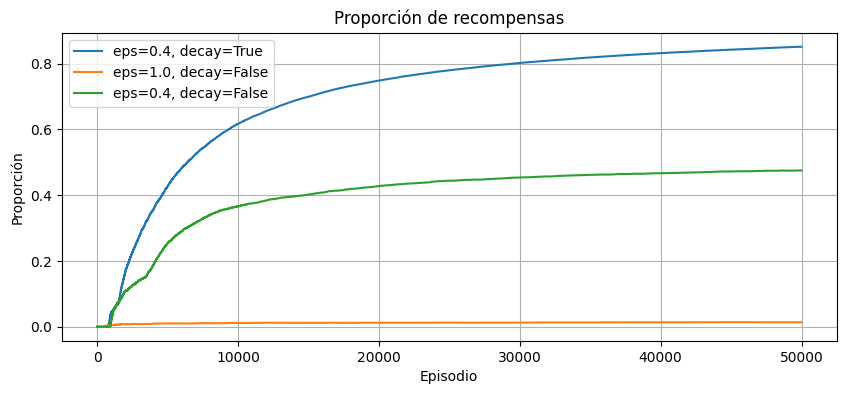

In [21]:
plot_comparative(dict_stats_4)

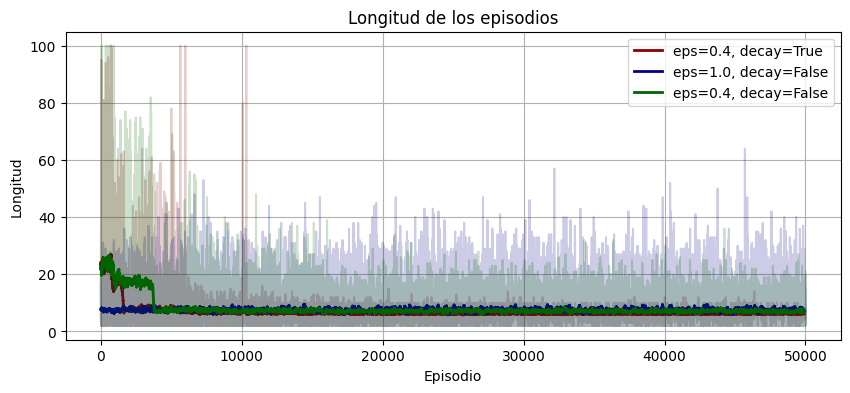

In [22]:
plot_len_comparative(dict_len_4)

En este caso, debemos observar las gráficas de manera conjunta, pues puede que si observarmos la de las longitudes de los episodios de forma individual, podamos llegar a malinterpretarla. Esto es, porque parece que los episodios convergen para todos los agentes, pero si vemos la gráfica de las recompensas promedio vemos que en el caso de la política de comportamiento uniforme, apenas se eleva el promedio. Esto, junto con las longitudes, nos dice que, en este entorno pequeño con agujeros presentes en el mapa, el agente no para de caerse por estos agujeros al tener una exploración extrema, poniendo de manifiesto su inutilidad en este caso. Para los otros dos casos, observamos lo mismo que veíamos en el caso On-Policy, es decir, para decaimiento del $\epsilon$, la política de comportamiento explota más tras unos primeros episodios exploradores, y consigue alcanzar más veces la meta, que en el caso de no usar decaimiento. Aunque, viendo la tendencia de la longitud del episodio para $\epsilon$ sin decaimiento, vemos que se ha aprendido la ruta óptima.

No obstante, no podemos limitarnos únicamente a este estudio pues, recordemos, off-policy usa dos políticas, y nos interesa saber si la objetivo ha aprendido o no (aunque en este caso, en el caso uniforme ya podemos ir teorizando de que no).  Es por ello que, en la siguiente sección, vamos a ver la política objetivo aprendida, de manera visual.

## Evaluación 4x4

Observemos las políticas finales obtenidas para cada agente (acción con mayor valor $Q$) vemos como estas son distintas, pero consigue llegar desde el estado inicial, al estado final.

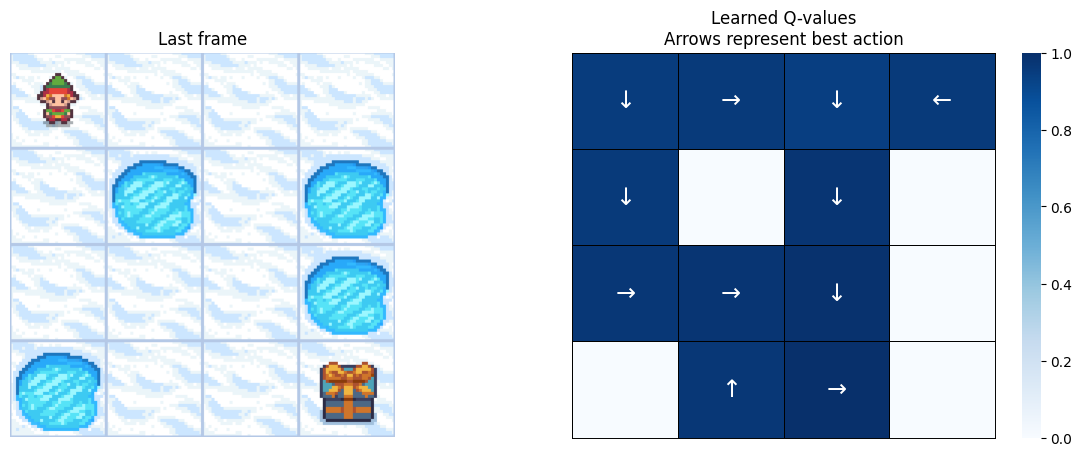

In [23]:
env4.reset(seed=SEED)
plot_q_values_map(agent_4.get_Q(), env4, 4)

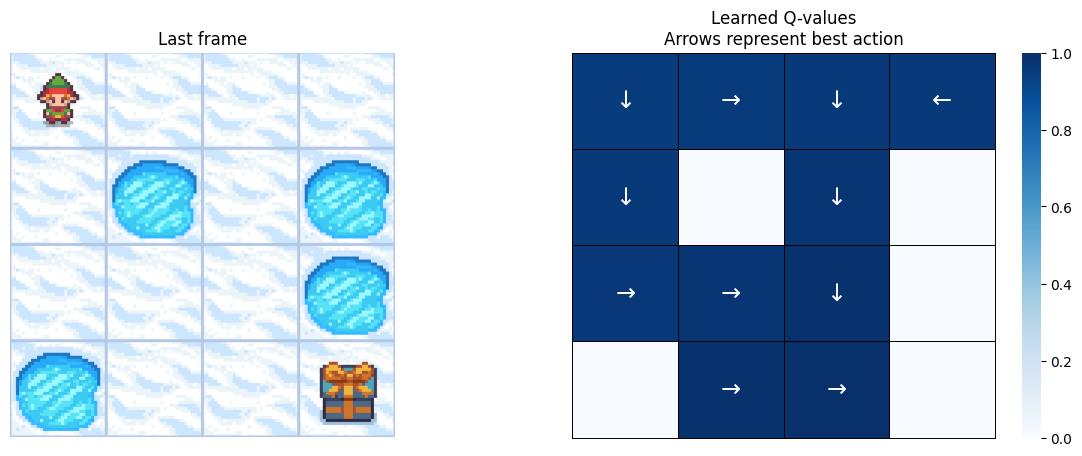

In [24]:
plot_q_values_map(agent_4_2.get_Q(), env4, 4)

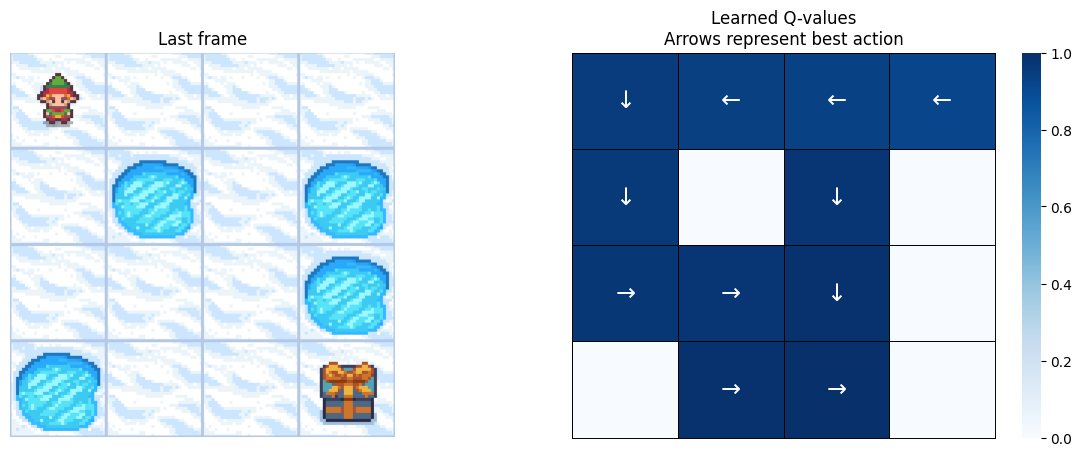

In [25]:
plot_q_values_map(agent_4_3.get_Q(), env4, 4)

In [26]:
# Ejecutar un episodio utilizando la política greedy y capturar los fotogramas.
total_reward, len_episode, frames = run_episode_greedy(agent_4)

# Crear el GIF a partir de los fotogramas capturados.
gif_path_4 = frames_to_gif(frames, "FL_4x4_MCOff.gif")
print("GIF guardado en:", gif_path_4)

GIF guardado en: FL_4x4_MCOff.gif


In [27]:
display_gif(gif_path_4)

## Caso 8x8

Vamos a evaluar ahora el aprendizaje del agente sobre el caso 8x8. En este caso, usaremos de nuevo tres agentes. El que use decay, tendrá un epsilon inicial de 1, para ayudarle a explorar en los episodios finales, y que consiga explorar el máximo terreno posible, lo que sabemos que es beneficioso para los métodos off-policy. Para el caso de no usar decay, como queremos que la política de comportamiento sea exploratoria, establecemos valores fijos de $\epsilon$ altos.

In [41]:
env8 = make_env_fl(name_fl, "8x8", "rgb_array", max_episode_steps=100)
agent_8 = AgentMonteCarloOffPolicy(env8, epsilon=1.0, decay=True, discount_factor=0.99)
agent_8_2 = AgentMonteCarloOffPolicy(env8, epsilon=0.6, decay=False, discount_factor=0.99)
agent_8_3 = AgentMonteCarloOffPolicy(env8, epsilon=0.4, decay=False, discount_factor=0.99)

In [42]:
n_episodes = 50000

list_stats_8, list_len_8 = train(agent_8, n_episodes)

 10%|█         | 5019/50000 [00:26<05:04, 147.95it/s]

success: 0.0, epsilon: 0.19996000799840033


 20%|██        | 10019/50000 [01:02<04:11, 159.18it/s]

success: 0.0, epsilon: 0.0999900009999


 30%|███       | 15029/50000 [01:38<03:41, 157.87it/s]

success: 0.0, epsilon: 0.06666222251849876


 40%|████      | 20021/50000 [02:14<03:31, 141.57it/s]

success: 0.0, epsilon: 0.04999750012499375


 50%|█████     | 25029/50000 [02:50<03:01, 137.87it/s]

success: 0.0, epsilon: 0.03999840006399744


 60%|██████    | 30017/50000 [03:27<03:21, 99.37it/s]

success: 0.0, epsilon: 0.033332222259258026


 70%|███████   | 35013/50000 [04:05<02:34, 96.96it/s]

success: 0.0, epsilon: 0.02857061226822091


 80%|████████  | 40011/50000 [04:43<01:40, 99.47it/s]

success: 0.0, epsilon: 0.02499937501562461


 90%|█████████ | 45030/50000 [05:21<00:41, 119.82it/s]

success: 0.0, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [06:00<00:00, 138.83it/s]


In [30]:
list_stats_8_2, list_len_8_2 = train(agent_8_2, n_episodes)

 10%|█         | 5067/50000 [00:11<01:38, 457.59it/s]

success: 0.002695439639780373, epsilon: 1.0


 20%|██        | 10060/50000 [00:22<02:07, 313.72it/s]

success: 0.002121067724890187, epsilon: 1.0


 30%|███       | 15051/50000 [00:33<01:41, 343.28it/s]

success: 0.0019995309519267907, epsilon: 1.0


 40%|████      | 20062/50000 [00:44<01:01, 484.17it/s]

success: 0.0019392329144450934, epsilon: 1.0


 50%|█████     | 25080/50000 [00:56<00:56, 438.58it/s]

success: 0.001939960426672355, epsilon: 1.0


 60%|██████    | 30040/50000 [01:07<00:43, 455.33it/s]

success: 0.0017780365898936294, epsilon: 1.0


 70%|███████   | 35092/50000 [01:18<00:31, 470.15it/s]

success: 0.0017463909067659685, epsilon: 1.0


 80%|████████  | 40069/50000 [01:29<00:21, 466.86it/s]

success: 0.0016508545184202223, epsilon: 1.0


 90%|█████████ | 45041/50000 [01:41<00:10, 469.34it/s]

success: 0.0016412415945957525, epsilon: 1.0


100%|██████████| 50000/50000 [01:52<00:00, 445.82it/s]


In [31]:
list_stats_8_3, list_len_8_3 = train(agent_8_3, n_episodes)

 10%|█         | 5031/50000 [00:29<04:29, 167.12it/s]

success: 0.0, epsilon: 0.4


 20%|██        | 10032/50000 [00:58<03:27, 192.97it/s]

success: 0.0, epsilon: 0.4


 30%|███       | 15028/50000 [01:28<03:45, 154.86it/s]

success: 0.0, epsilon: 0.4


 40%|████      | 20026/50000 [01:57<02:46, 179.69it/s]

success: 0.0, epsilon: 0.4


 50%|█████     | 25023/50000 [02:26<02:20, 177.39it/s]

success: 0.0, epsilon: 0.4


 60%|██████    | 30025/50000 [02:56<01:53, 175.98it/s]

success: 0.0, epsilon: 0.4


 70%|███████   | 35031/50000 [03:26<01:24, 176.43it/s]

success: 0.0, epsilon: 0.4


 80%|████████  | 40023/50000 [03:55<00:54, 184.29it/s]

success: 0.0, epsilon: 0.4


 90%|█████████ | 45034/50000 [04:25<00:29, 169.97it/s]

success: 0.0, epsilon: 0.4


100%|██████████| 50000/50000 [04:55<00:00, 169.45it/s]


In [43]:
dict_stats_8 = {'eps=1.0, decay=True': list_stats_8, 'eps=0.6, decay=False': list_stats_8_2, 'eps=0.4, decay=False': list_stats_8_3}
dict_len_8 = {'eps=1.0, decay=True': list_len_8, 'eps=0.6, decay=False': list_len_8_2, 'eps=0.4, decay=False': list_len_8_3}

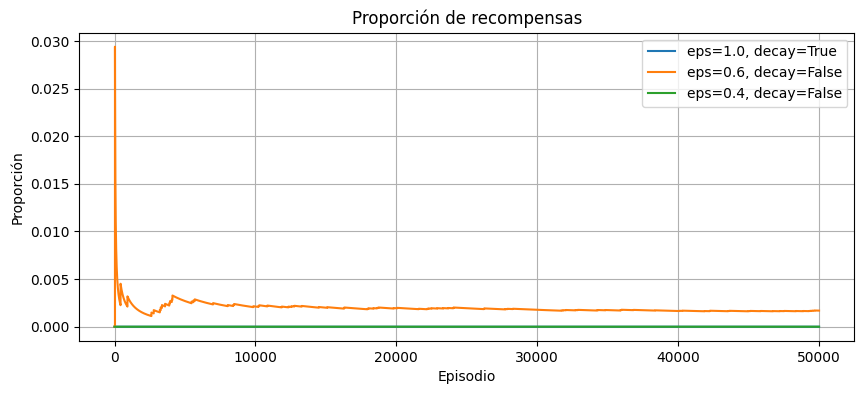

In [51]:
plot_comparative(dict_stats_8)

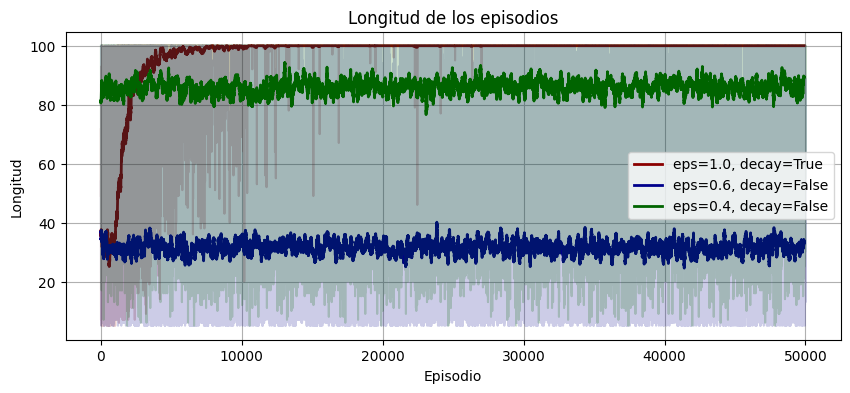

In [52]:
plot_len_comparative(dict_len_8)

Los resultados han sido desastrosos. El incremento de dificultad del entorno ha provocado que las políticas no se actualicen de manera correcta hacia el óptimo y, en el caso del agente que usa decaimiento y del que tiene $\epsilon$ fijo en 0.4, se hayan quedado estancadas en políticas subóptimas. En el caso del agente con $\epsilon$ 0.6, parece que los episodios duran menos, pero si nos fijamos en la gráfica de las recompensas promedio, esto parece ser porque la política subóptima en la que se ha quedado atrapado hace que caiga en un agujero antes durante cada episodio.

## Evaluación 8x8

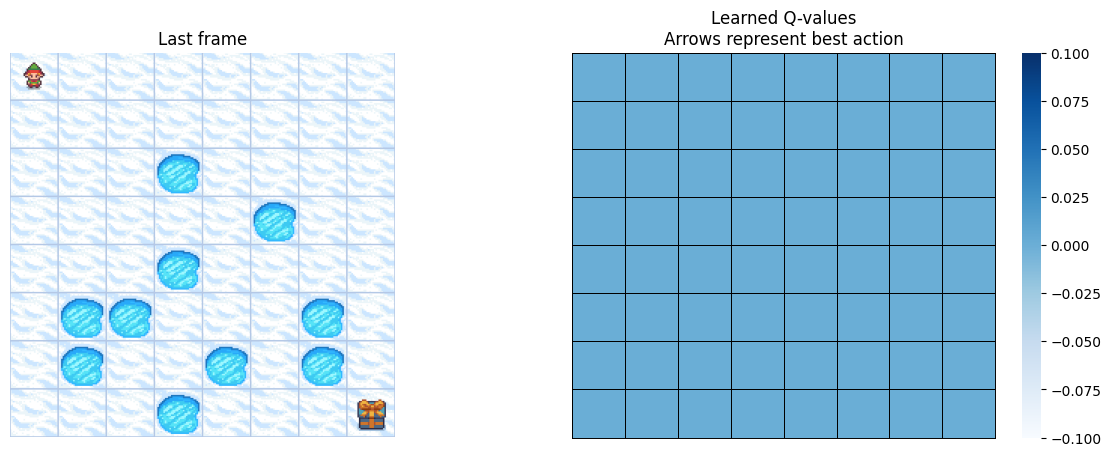

In [35]:
env8.reset(seed=SEED)
plot_q_values_map(agent_8.get_Q(), env8, 8)

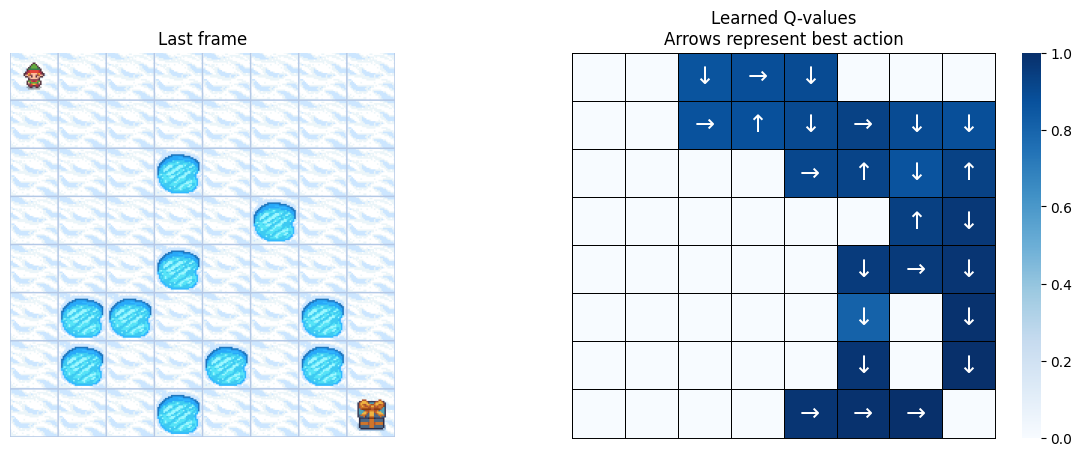

In [36]:
plot_q_values_map(agent_8_2.get_Q(), env8, 8)

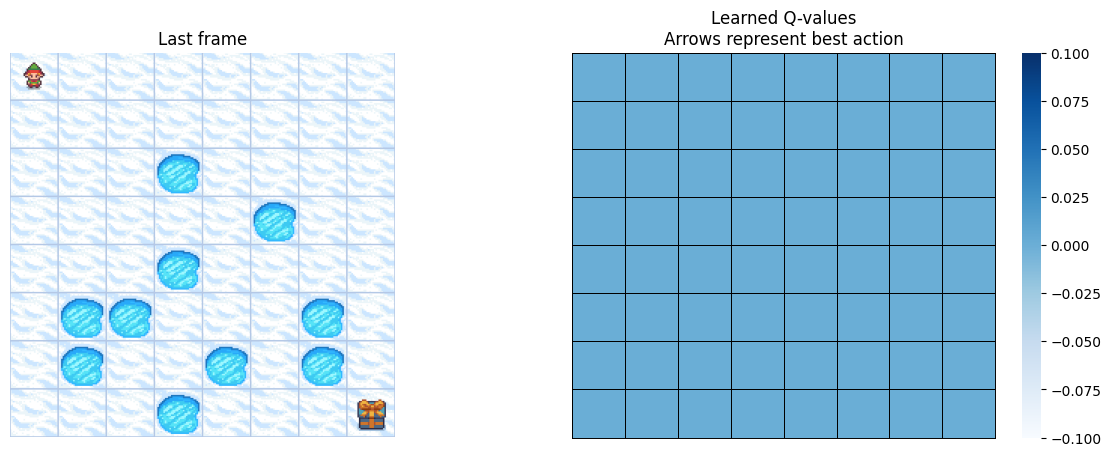

In [37]:
plot_q_values_map(agent_8_3.get_Q(), env8, 8)

Como era de esperar, ningún agente ha conseguido obtener unos buenos valores $Q$ que nos proporcionen información sobre hacia donde movernos en cada estado para alcanzar la ruta hacia el objetivo.

In [38]:
# Ejecutar un episodio utilizando la política greedy y capturar los fotogramas.
total_reward, len_episode, frames = run_episode_greedy(agent_8)

# Crear el GIF a partir de los fotogramas capturados.
gif_path_8 = frames_to_gif(frames, "FL_8x8_MCOff.gif")
print("GIF guardado en:", gif_path_8)

GIF guardado en: FL_8x8_MCOff.gif


In [39]:
display_gif(gif_path_8)

Almacenamos las listas con los resultados para su posterior estudio.

In [40]:
import pickle

with open("stats_4_MCoff.pkl", "wb") as f:
    pickle.dump(list_stats, f)

with open("len_4_MCoff.pkl", "wb") as f:
    pickle.dump(list_len, f)

with open("stats_8_MCoff.pkl", "wb") as f:
    pickle.dump(list_stats_8, f)

with open("len_8_MCoff.pkl", "wb") as f:
    pickle.dump(list_len_8, f)